**1. Read & Load data into Python**

In [2]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
print(tf. __version__)
print(tf.config.get_visible_devices())

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [4]:
# folder_images_train_F = r"/content/drive/MyDrive/DAAN 570 Deep Learning Project/gender_images/Training/female"
# folder_images_train_M = r"/content/drive/MyDrive/DAAN 570 Deep Learning Project/gender_images/Training/male"
# folder_images_test_F = r"/content/drive/MyDrive/DAAN 570 Deep Learning Project/gender_images/Validation/female"
# folder_images_test_M = r"/content/drive/MyDrive/DAAN 570 Deep Learning Project/gender_images/Validation/male"
# female_train_img_list = []
# male_train_img_list = []
# female_test_img_list = []
# male_test_img_list = []

In [5]:
# def FolderImages(pathvar, imglistname):
#    for dirpath, _, filenames in os.walk(pathvar):
#        for path_image in filenames:
#             image = os.path.abspath(os.path.join(dirpath, path_image))
#             with Image.open(image) as img:
#                 width, height = img.size
#                 imglistname.append(
#                     {
#                         'image': path_image,
#                         'width': width,
#                         'height': height
#                     }
#                 )
#                 pd.DataFrame(imglistname)

# # Get image dimensions into a list
# FolderImages(folder_images_train_F, female_train_img_list)
# FolderImages(folder_images_train_M, male_train_img_list)
# FolderImages(folder_images_test_F, female_test_img_list)
# FolderImages(folder_images_test_M, male_test_img_list)

In [4]:
image_size = (224, 224)
batch_size = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path_training,
                                                               seed=1993, 
                                                               image_size = image_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(path_validation,
                                                             seed=1993,
                                                             image_size = image_size)

Found 47009 files belonging to 2 classes.
Found 11649 files belonging to 2 classes.


In [8]:
os.scandir(path_training)
subfolders = sorted([file.path for file in os.scandir(path_training) if file.is_dir()])
print(subfolders)

['gender_images/Training/female', 'gender_images/Training/male']


In [5]:
one_hot_encoded_train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
one_hot_encoded_val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [12]:
# Normalize images
# normalization_layer = tf.keras.layers.Rescaling(1./255)

# normalized_train_img = zoo_training.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_train_img))
# normalized_valid_img = zoo_validation.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_valid_img))

In [7]:
one_hot_encoded_train_ds = one_hot_encoded_train_ds.prefetch(buffer_size=32)
one_hot_encoded_val_ds = one_hot_encoded_val_ds.prefetch(buffer_size=32)

**2. Build a model based on a convolutional neural network (use softmax as output activation function and categorical_crossentropy as a loss function).**

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
epochs = 15

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224)     0           ['input_2[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['sequential[1][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['rescaling_1[0][0]']        

                                                                                                  
 activation_7 (Activation)      (None, 28, 28, 512)  0           ['batch_normalization_6[0][0]']  
                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 28, 28, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 28, 28, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 512)  0          ['batch_normalization_7[0][0]']  
          

In [18]:
face_fit = model.fit(
  one_hot_encoded_train_ds,
  validation_data= one_hot_encoded_val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/15
1470/1470 [==============================] - 297s 197ms/step - loss: 0.2486 - accuracy: 0.8978 - val_loss: 0.1620 - val_accuracy: 0.9397
Epoch 2/15
1470/1470 [==============================] - 300s 204ms/step - loss: 0.1614 - accuracy: 0.9392 - val_loss: 0.1580 - val_accuracy: 0.9460
Epoch 3/15
1470/1470 [==============================] - 289s 197ms/step - loss: 0.1414 - accuracy: 0.9489 - val_loss: 0.1597 - val_accuracy: 0.9443
Epoch 4/15
1470/1470 [==============================] - 290s 197ms/step - loss: 0.1331 - accuracy: 0.9514 - val_loss: 0.1212 - val_accuracy: 0.9577
Epoch 5/15
1470/1470 [==============================] - 286s 194ms/step - loss: 0.1251 - accuracy: 0.9553 - val_loss: 0.1814 - val_accuracy: 0.9326
Epoch 6/15
1470/1470 [==============================] - 287s 195ms/step - loss: 0.1175 - accuracy: 0.9573 - val_loss: 0.0987 - val_accuracy: 0.9637
Epoch 7/15
1470/1470 [==============================] - 288s 196ms/step - loss: 0.1150 - accuracy: 0.9583 - val_

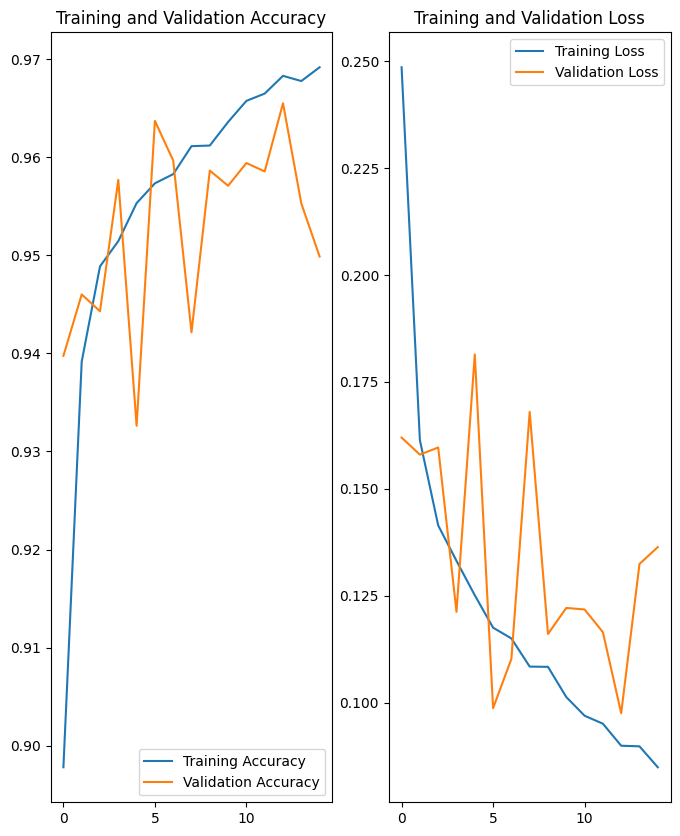

In [19]:
acc= face_fit.history['accuracy']
val_acc = face_fit.history['val_accuracy']

loss = face_fit.history['loss']
val_loss = face_fit.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(epochs)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
base_model = keras.applications.ResNet50V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [21]:
base_model.trainable = False

In [22]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [27]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])
resnet_fit = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/15
1470/1470 [==============================] - 55s 36ms/step - loss: 7.5379 - accuracy: 0.5057 - val_loss: 7.6462 - val_accuracy: 0.4986
Epoch 2/15
1470/1470 [==============================] - 52s 36ms/step - loss: 7.5398 - accuracy: 0.5056 - val_loss: 7.6462 - val_accuracy: 0.4986
Epoch 3/15
1470/1470 [==============================] - 52s 36ms/step - loss: 7.5398 - accuracy: 0.5056 - val_loss: 7.6462 - val_accuracy: 0.4986
Epoch 4/15
1470/1470 [==============================] - 52s 35ms/step - loss: 7.5398 - accuracy: 0.5056 - val_loss: 7.6462 - val_accuracy: 0.4986
Epoch 5/15
1470/1470 [==============================] - 51s 34ms/step - loss: 7.5398 - accuracy: 0.5056 - val_loss: 7.6462 - val_accuracy: 0.4986
Epoch 6/15
1469/1470 [============================>.] - ETA: 0s - loss: 7.5400 - accuracy: 0.5056

KeyboardInterrupt: 

In [ ]:
acc= resnet_fit.history['accuracy']
val_acc = resnet_fit.history['val_accuracy']

loss = resnet_fit.history['loss']
val_loss = resnet_fit.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(epochs)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [8]:
vgg_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)
vgg_model.trainable = False

80134624/80134624 [==============================] - 2s 0us/step


In [9]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = vgg_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
epochs=30
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
vgg19_fit = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/30
1470/1470 [==============================] - 95s 59ms/step - loss: 7.1020 - accuracy: 0.4787 - val_loss: 6.0309 - val_accuracy: 0.5560
Epoch 2/30
1470/1470 [==============================] - 85s 58ms/step - loss: 5.2861 - accuracy: 0.5935 - val_loss: 4.7802 - val_accuracy: 0.6237
Epoch 3/30
1470/1470 [==============================] - 84s 57ms/step - loss: 4.1999 - accuracy: 0.6701 - val_loss: 3.7415 - val_accuracy: 0.7027
Epoch 4/30
1470/1470 [==============================] - 84s 57ms/step - loss: 4.7054 - accuracy: 0.6495 - val_loss: 4.7196 - val_accuracy: 0.6474
Epoch 5/30
1470/1470 [==============================] - 84s 57ms/step - loss: 3.4992 - accuracy: 0.7230 - val_loss: 3.0243 - val_accuracy: 0.7554
Epoch 6/30
1470/1470 [==============================] - 86s 58ms/step - loss: 2.9113 - accuracy: 0.7648 - val_loss: 2.7802 - val_accuracy: 0.7742
Epoch 7/30
1470/1470 [==============================] - 86s 58ms/step - loss: 2.6985 - accuracy: 0.7811 - val_loss: 2.6669 -

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


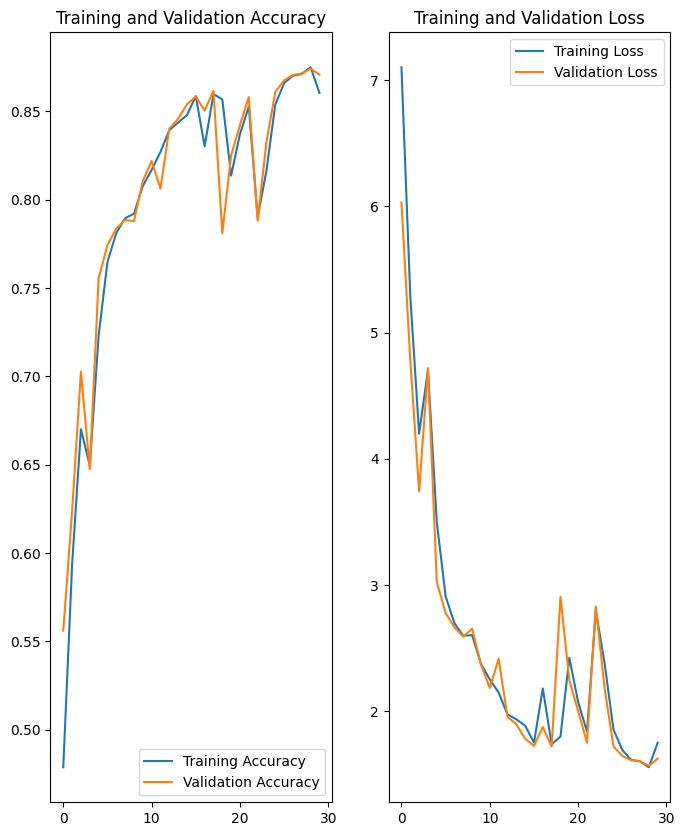

In [10]:
acc= vgg19_fit.history['accuracy']
val_acc = vgg19_fit.history['val_accuracy']

loss = vgg19_fit.history['loss']
val_loss = vgg19_fit.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(epochs)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()